In [23]:
from zipfile import ZipFile
import numpy as np
from scipy.signal import savgol_filter
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [7]:
class PositionInterpolator:
    def __init__(self):
        df = pd.read_csv("braidz_stimuli_calibration.csv")
        self.screen = df["circle"].values
        self.heading = df["angle"].values

    def heading2screen(self, heading):
        return np.interp(heading, self.heading, self.screen, period=2 * np.pi)

    def screen2heading(self, screen):
        return np.interp(screen, self.screen, self.heading, period=640)


posint = PositionInterpolator()

In [72]:
base_folder = "/gpfs/soma_fs/nfc/nfc3008/Experiments/"
exp_list = [
    "20250410_120718.braidz",
    "20250411_175919.braidz",
    "20250421_174810.braidz",
    "20250422_171703.braidz",
    "20250425_195715.braidz",
    "20250427_170153.braidz",
]

results = {}
for exp in tqdm(exp_list, desc="Processing experiments"):
    file = os.path.join(base_folder, exp)

    # check if file exists
    if not os.path.exists(file):
        print(f"File {file} does not exist.")
        continue

    with ZipFile(file, mode="r") as zf:
        df = pd.read_csv(
            zf.open("kalman_estimates.csv.gz"),
            comment="#",
            compression="gzip",
        )

        # check if .braidz file has a `stim.csv`
        if "stim.csv" not in zf.namelist():
            print(f"File {file} does not contain stim.csv.")
            continue

        stim = pd.read_csv(zf.open("stim.csv"))

        results[exp] = {
            "linear_velocity": [],
            "angular_velocity": [],
            "fly_heading": [],
            "stim_heading": [],
            "heading_diff": [],
        }
        # loop over all stimulus presentations
        for idx, row in tqdm(
            stim.iterrows(), desc="Processing stimuli", total=len(stim)
        ):
            obj_id = int(row["obj_id"])
            frame = int(row["frame"])

            # find obj_id in df
            grp = df[df["obj_id"] == obj_id]

            # find frame in grp
            frame_indices = np.where(grp["frame"] == frame)[0]

            if len(frame_indices) == 0:
                print(f"Frame {frame} not found in obj_id {obj_id}.")
                continue

            stim_idx = frame_indices[0]

            if stim_idx - 50 < 0 or stim_idx + 100 >= len(grp):
                print(f"Frame {frame} is out of bounds for obj_id {obj_id}.")
                continue

            newgrp = grp.copy()

            # apply savgol filter to data
            for col in ["x", "y", "z", "xvel", "yvel", "zvel"]:
                newgrp[col] = savgol_filter(
                    newgrp[col], 21, 3
                )  # Use newgrp here instead of grp

            # calculate linear velocity using filtered data
            linear_velocity = np.sqrt(
                newgrp["xvel"].to_numpy() ** 2
                + newgrp["yvel"].to_numpy() ** 2
                + newgrp["zvel"].to_numpy() ** 2
            )

            # calculate angular velocity using filtered data
            theta = np.arctan2(newgrp["yvel"].to_numpy(), newgrp["xvel"].to_numpy())
            theta_unwrap = np.unwrap(theta)
            # Assuming 0.01 seconds between frames - adjust if needed
            angular_velocity = savgol_filter(
                np.gradient(theta_unwrap, 0.01), window_length=21, polyorder=3
            )

            # calculate heading
            fly_heading = row["heading"]
            stim_heading = posint.screen2heading(row["stim_position_screen"])

            # calculate heading difference
            heading_diff = fly_heading - stim_heading
            heading_diff = np.arctan2(np.sin(heading_diff), np.cos(heading_diff))

            # save data
            results[exp]["linear_velocity"].append(
                linear_velocity[stim_idx - 50 : stim_idx + 100]
            )
            results[exp]["angular_velocity"].append(
                angular_velocity[stim_idx - 50 : stim_idx + 100]
            )
            results[exp]["fly_heading"].append(fly_heading)
            results[exp]["stim_heading"].append(stim_heading)
            results[exp]["heading_diff"].append(heading_diff)

Processing experiments:   0%|          | 0/6 [00:03<?, ?it/s]


In [90]:
import yaml

for exp in tqdm(exp_list, desc="Processing experiments"):
    file = os.path.join(base_folder, exp)

    # check if file exists
    if not os.path.exists(file):
        print(f"File {file} does not exist.")
        continue

    with ZipFile(file, mode="r") as zf:
        config = yaml.load(zf.read("config.yaml"), Loader=yaml.FullLoader)
        print(config["visual_stimuli"]["stimuli"][1]["position_type"])

Processing experiments: 100%|██████████| 6/6 [00:00<00:00, 85.52it/s]

closed-loop
closed-loop
closed-loop
closed-loop
closed-loop
File /gpfs/soma_fs/nfc/nfc3008/Experiments/20250427_170153.braidz does not exist.


In [89]:
config["visual_stimuli"]["stimuli"][1]["position_type"]

'closed-loop'

In [70]:
# First, make sure all lists are converted to numpy arrays
for exp in results:
    for key in results[exp]:
        if isinstance(results[exp][key], list):
            results[exp][key] = np.array(results[exp][key])

    # Now calculate peak_angular_velocity for each experiment
    # This assumes angular_velocity is a 2D array where each row is a trace
    peak_values = []
    for trace in results[exp]["angular_velocity"]:
        # Take absolute value and find maximum in the range [50:100]
        peak = np.max(np.abs(trace[50:100]))
        peak_values.append(peak)

    # Add the new key with the calculated peak values
    results[exp]["peak_angular_velocity"] = np.array(peak_values)

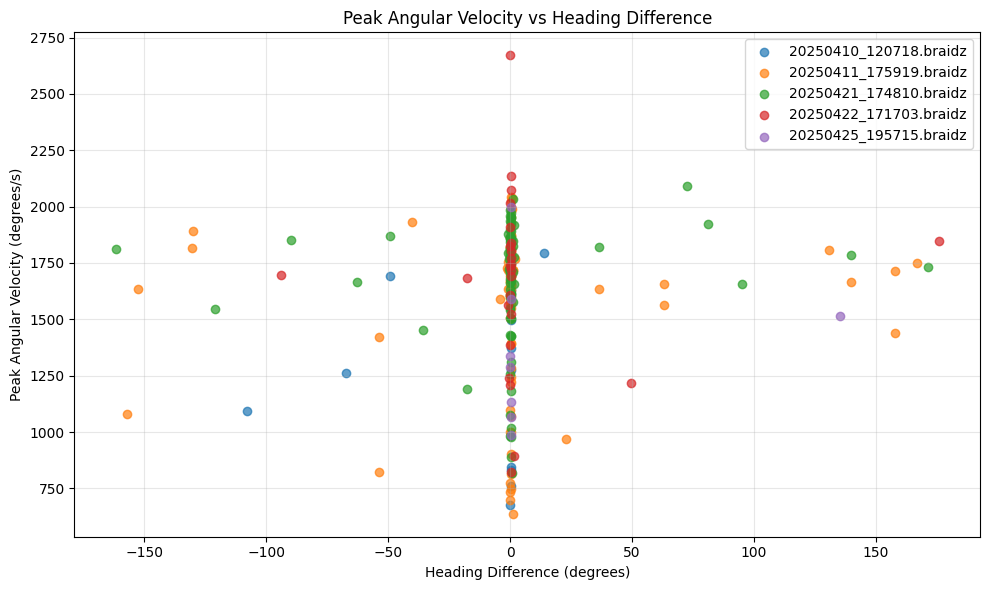

In [71]:
import numpy as np

# Create a figure
plt.figure(figsize=(10, 6))

# Process each experiment and add to the plot
for exp in results:
    # Convert heading differences from radians to degrees
    heading_diff_deg = np.rad2deg(results[exp]["heading_diff"])

    # Get the peak angular velocities
    peak_ang_vel = np.rad2deg(results[exp]["peak_angular_velocity"])

    # Plot this experiment's data with a label
    plt.scatter(heading_diff_deg, peak_ang_vel, alpha=0.7, label=exp)

# Add labels and title
plt.xlabel("Heading Difference (degrees)")
plt.ylabel(
    "Peak Angular Velocity (degrees/s)"
)  # Assuming angular velocity is also in rad/s
plt.title("Peak Angular Velocity vs Heading Difference")

# Add a legend if there are multiple experiments
if len(results) > 1:
    plt.legend()

# Add a grid for better readability
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()